# Helicopter Dataset 
Goals: Read in data. Analyse!

Data information: 
The use case is relative to flight test helicopters vibration measurements. The dataset has been collected and released by Airbus SAS. A main challenge in flight tests of heavily instrumented aircraft (helicopters or airplanes alike) is the validation of the generated data because of the number of signals to validate. Manual validation requires too much time and manpower. Automation of this validation is crucial. 
    
In this case, different accelerometers are placed at different positions of the helicopter, in different directions (longitudinal, vertical, lateral) to measure the vibration levels in all operating conditions of the helicopter. The data set consists of multiple 1D time series with a constant frequency of 1024 Hz taken from different flights, cut into 1 minute sequences.

We are interested in the detection of abnormal sensor behaviour. Sensors are recorded at 1024Hz and we provide sequences of one-minute length. 

Training data
The training dataset is composed of 1677 one-minute-sequences @1024Hz of accelerometer data measured on test helicopters at various locations, in various angles (X, Y, Z), on different flights. All data has been multiplied by a factor so that absolute values are meaningless, but no other normalization procedure was carried out. All sequences are considered as normal and should be used to learn normal behaviour of accelerometer data.
Validation Data
The validation dataset is composed of 594 one-minute-sequences of accelerometer data measured on test helicopters at various locations, in various angles (X, Y, Z). Locations and angles may or may not be identical to those of the training dataset. Sequences are to be tested with the normal behaviour learnt from the training data to detect abnormal behaviour. The amount of abnormal sequences in the validation dataset is a priori unknown.

Datasets are provided in a HDF5 format that can be decoded by many standard machine learning modules (like pandas for instance):
  +  In the training dataset, the dataframe is called "dftrain"
  +  In the validation dataset, the dataframe is called "dfvalid"
Each dataframe has 61440 columns corresponding all time steps contained in one minute at 1024Hz and are named from 0 to 61339.

- THOUGHTS AND DIFFICULTIES
- No access to location (nothing to barycentre?) (jk i end up barycentering the vmds)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import mat4py # .mat file conversion

from scipy.signal import welch, find_peaks, cwt # Signal Processing

import stumpy # Matrix Profile
from stumpy.floss import _cac # One sided cac

import tables
import ot # Optimal Transport

from vmdpy import VMD # Variational Mode Decomposition 

from ruptures.metrics import hausdorff # Quantifying Break Point Discrepancies

# Utils
import time
import os
loc = os.getcwd() 

# Matplotlib Params
import matplotlib
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Pipeline
1. check for na and other oddities and remove (not relevant in this case)
1.5 Concatenate everything into one dataframe
2. compute vmd of each series (5?)
3. Welch, log // max
4. Append cleaned data together (keeping vmd modes separate)
5. For each stack series, compute stump and cac 
6. barycenter cac's together after subsampling
7. find peaks and profit

Additional explorations
- Make some plots first to see what is happening
- Feature engineering??
- Encode decode?? We know what normality should look like
- Wavelet transform, if we know what we should be looking for

In [2]:
train_data = pd.read_hdf("/Users/wang_to/Documents/University/Anomaly_detection/anomalies/helicopter/dftrain.h5")
anomaly_data = pd.read_hdf("/Users/wang_to/Documents/University/Anomaly_detection/anomalies/helicopter/dfvalid.h5")
ground_truth_data = pd.read_csv("/Users/wang_to/Documents/University/Anomaly_detection/anomalies/helicopter/dfvalid_groundtruth.csv")
# read in data; note you need to go to https://www.research-collection.ethz.ch/handle/20.500.11850/415151


In [3]:
len(train_data)

1677

In [4]:
sample_freq = 1024 # in Hz
total_readings = 61440
total_time = 61440 / 1024 
num_experiments = len(train_data) + len(anomaly_data)
num_norm = len(train_data)
num_anom = len(anomaly_data)
# number of abnormal sequences in validation set is apriori unknown
# all data in the training set is normal


In [5]:
train_data # take a look at the data

,0,1,2,3,4,5,6,7,8,9,...,61430,61431,61432,61433,61434,61435,61436,61437,61438,61439
0,0.041259,0.041259,0.032573,0.023887,0.029315,0.041259,0.045602,0.038001,0.030401,0.032573,...,0.034744,-0.007600,-0.003257,0.065145,0.047773,-0.009772,0.031487,0.096632,0.077089,0.040173
1,-0.211722,-0.264924,-0.274696,-0.236694,-0.156349,-0.059716,0.005429,0.046687,0.153091,0.281210,...,0.260581,-0.004343,-0.241037,-0.636252,-0.953292,-0.980436,-0.846888,-0.838202,-0.880546,-0.739398
2,0.214105,0.154930,0.136640,0.013987,-0.038733,-0.015063,-0.111894,-0.104363,0.047340,-0.054871,...,0.040884,0.375490,0.699337,0.965085,1.086662,1.132926,1.279249,1.296464,0.937112,0.451879
3,-0.154837,-0.127768,-0.217638,-0.284770,-0.299929,-0.270694,-0.077960,0.092036,0.076877,0.154837,...,-0.286936,-0.171079,-0.036814,-0.024904,0.031400,0.140761,-0.011911,-0.173244,-0.063884,0.081208
4,-1.022780,-0.916376,-0.676425,-0.461445,-0.330069,-0.122690,0.178064,0.489675,0.799115,0.931577,...,1.009751,1.134613,0.836030,0.479903,0.109661,-0.285553,-0.628651,-0.916376,-1.010837,-0.804544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1672,-0.063989,0.017228,0.015997,-0.321177,-0.503300,-0.535295,-0.562367,-0.600515,-0.573442,-0.317485,...,-0.121826,-0.134131,-0.111981,-0.057836,-0.073834,-0.125517,-0.082448,-0.036917,-0.114442,-0.183354
1673,0.993037,0.726052,0.341885,0.286314,0.535177,0.605245,0.198124,-0.375711,-0.579875,-0.495310,...,0.038658,0.188460,0.273025,0.045907,-0.108727,0.072484,0.415577,0.356382,-0.096646,-0.280273
1674,0.570550,0.253578,-0.193841,-0.502279,-0.657108,-0.838757,-0.971642,-0.881427,-0.700996,-0.520566,...,-0.146295,0.128008,0.162143,0.018287,-0.017068,0.087777,0.062175,-0.041450,-0.140199,-0.247482
1675,0.630677,0.605010,0.477897,0.155225,-0.441229,-0.679566,-0.515786,-0.424118,-0.183336,0.394784,...,0.229781,-0.041556,-0.176003,-0.301894,-0.177225,0.033001,0.025667,0.088001,0.206559,0.003667


In [6]:
anomaly_data

,0,1,2,3,4,5,6,7,8,9,...,61430,61431,61432,61433,61434,61435,61436,61437,61438,61439
0,0.070650,0.085524,0.076847,0.085524,0.120229,0.140061,0.107834,0.048340,0.014874,0.030987,...,0.018592,-0.017353,-0.049579,-0.061974,-0.022311,0.052058,0.091721,0.075608,0.045861,0.027268
1,-0.300685,-0.882656,-1.733789,-2.181179,-1.942328,-1.719240,-1.981126,-2.323034,-2.325459,-2.349708,...,0.454665,-0.782024,-1.725302,-1.829572,-1.170004,-0.278861,-0.152767,-1.035424,-2.312123,-3.199628
2,-0.056398,-0.152028,-0.058850,0.140994,0.170419,0.154480,0.270954,0.359228,0.334708,0.349420,...,0.023295,-0.019617,-0.062528,-0.094405,-0.105439,-0.123830,-0.166741,-0.159385,-0.106665,-0.131186
3,0.030618,0.020412,0.058747,0.124712,0.155828,0.161553,0.167777,0.170515,0.165038,0.141141,...,-0.073682,-0.052524,-0.023897,-0.009210,0.016429,0.058000,0.097828,0.114755,0.090360,0.054764
4,-1.071597,-6.912540,-13.677612,-16.463519,-15.790084,-11.653620,-7.668311,-9.942997,-14.321553,-13.704648,...,-5.227723,-6.107613,-6.577051,-6.123589,-5.324806,-4.965969,-4.464579,-3.442138,-3.794831,-6.133420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,-18.291415,-18.288957,-18.285270,-18.282812,-18.280354,-18.276668,-18.271752,-18.268065,-18.268065,-18.270523,...,-19.514201,-19.514201,-19.515430,-19.514201,-19.511744,-19.506828,-19.501912,-19.496996,-19.493310,-19.490852
590,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,...,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138
591,0.031800,-0.143735,-0.059784,0.248039,0.283655,-0.010176,-0.153911,0.069960,0.283655,0.183167,...,0.185711,0.151367,0.166631,0.171719,0.153911,0.160271,0.141191,0.050880,-0.020352,0.025440
592,-0.026635,-0.026635,-0.006721,0.009210,-0.008464,-0.036094,-0.039082,-0.026137,-0.017674,-0.017674,...,0.104549,0.103802,0.104798,0.094841,0.073184,0.058747,0.062978,0.081399,0.103056,0.113760


In [7]:
print(f"Train: {train_data.shape} Anomaly: {anomaly_data.shape}") #61440 long time series, 1677 normal, 594 in anomalous (anomaly_data can consist of either anomalous or normal data)

Train: (1677, 61440) Anomaly: (594, 61440)


In [8]:
ind = (ground_truth_data["anomaly"]==1.0).values
anomaly_data[ind] # take out only anomalous data

,0,1,2,3,4,5,6,7,8,9,...,61430,61431,61432,61433,61434,61435,61436,61437,61438,61439
1,-0.300685,-0.882656,-1.733789,-2.181179,-1.942328,-1.719240,-1.981126,-2.323034,-2.325459,-2.349708,...,0.454665,-0.782024,-1.725302,-1.829572,-1.170004,-0.278861,-0.152767,-1.035424,-2.312123,-3.199628
4,-1.071597,-6.912540,-13.677612,-16.463519,-15.790084,-11.653620,-7.668311,-9.942997,-14.321553,-13.704648,...,-5.227723,-6.107613,-6.577051,-6.123589,-5.324806,-4.965969,-4.464579,-3.442138,-3.794831,-6.133420
5,-0.106524,0.129788,0.677099,1.311344,1.306447,0.493438,-0.353855,-0.494662,-0.194681,0.006122,...,-1.497455,-0.877903,0.247331,1.433785,1.881920,1.730093,1.181557,0.019591,-1.065238,-1.054218
8,-8.059100,-6.846179,-3.552738,-2.357022,-3.582232,-3.882082,-3.342597,-4.637853,-7.660937,-9.410885,...,0.087252,0.705386,0.956081,0.218743,-1.472217,-2.887905,-2.934604,-1.761008,-0.726278,-0.974514
12,-1.274245,-2.363014,-2.666521,-2.281116,-1.946295,-1.731914,-2.039033,-2.998932,-3.162730,-2.590644,...,-0.451646,-1.011688,-1.111652,-0.423945,0.233652,-0.166206,-1.198369,-1.665672,-1.063477,-0.232447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585,-4.916443,-3.455453,-1.728939,-1.494938,-3.295411,-5.605109,-5.300786,-2.630994,-2.540061,-5.428093,...,-9.689818,-8.368259,-4.618183,-2.992301,-4.538162,-6.436842,-7.432255,-7.458929,-4.677592,-0.415867
587,-1.112990,-2.241897,-4.031985,-4.862136,-4.017293,-2.865122,-2.293322,-2.551673,-4.491140,-6.636308,...,-0.915859,-2.117007,-2.388826,-2.412090,-3.020622,-3.842202,-3.667111,-2.768393,-2.206389,-2.020278
589,-18.291415,-18.288957,-18.285270,-18.282812,-18.280354,-18.276668,-18.271752,-18.268065,-18.268065,-18.270523,...,-19.514201,-19.514201,-19.515430,-19.514201,-19.511744,-19.506828,-19.501912,-19.496996,-19.493310,-19.490852
590,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,...,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138


In [9]:
# Parameters for VMD  
alpha = 2000      # Moderate bandwidth constraint  
tau = 0.          # Noise-tolerance (no strict fidelity enforcement)  
num_modes = 5     # Num modes  
DC = 0            # No DC part imposed  
init = 0          # Initialize omegas uniformly  
tol = 1e-7        # Optimization Convergence Tolerance

nperseg = total_readings // 8 
num_modes = 5
fs = sample_freq #1024

sample_rate = 5
seg_norm = 20
seg_anom = 10 # take first 20 normals and first 10 of the actual anomalous data

train_test_data = train_data.iloc[:seg_norm, ::sample_rate] #downsample to every 5th data point
anomaly_test_data = anomaly_data[ind].iloc[:seg_anom, ::sample_rate]

num_samples = len(train_test_data.columns)


In [10]:
anomaly_data[ind] # notice that index 590 has a broken sensor: only returns the same values, so computing vmd etc. just returns NaN.

,0,1,2,3,4,5,6,7,8,9,...,61430,61431,61432,61433,61434,61435,61436,61437,61438,61439
1,-0.300685,-0.882656,-1.733789,-2.181179,-1.942328,-1.719240,-1.981126,-2.323034,-2.325459,-2.349708,...,0.454665,-0.782024,-1.725302,-1.829572,-1.170004,-0.278861,-0.152767,-1.035424,-2.312123,-3.199628
4,-1.071597,-6.912540,-13.677612,-16.463519,-15.790084,-11.653620,-7.668311,-9.942997,-14.321553,-13.704648,...,-5.227723,-6.107613,-6.577051,-6.123589,-5.324806,-4.965969,-4.464579,-3.442138,-3.794831,-6.133420
5,-0.106524,0.129788,0.677099,1.311344,1.306447,0.493438,-0.353855,-0.494662,-0.194681,0.006122,...,-1.497455,-0.877903,0.247331,1.433785,1.881920,1.730093,1.181557,0.019591,-1.065238,-1.054218
8,-8.059100,-6.846179,-3.552738,-2.357022,-3.582232,-3.882082,-3.342597,-4.637853,-7.660937,-9.410885,...,0.087252,0.705386,0.956081,0.218743,-1.472217,-2.887905,-2.934604,-1.761008,-0.726278,-0.974514
12,-1.274245,-2.363014,-2.666521,-2.281116,-1.946295,-1.731914,-2.039033,-2.998932,-3.162730,-2.590644,...,-0.451646,-1.011688,-1.111652,-0.423945,0.233652,-0.166206,-1.198369,-1.665672,-1.063477,-0.232447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585,-4.916443,-3.455453,-1.728939,-1.494938,-3.295411,-5.605109,-5.300786,-2.630994,-2.540061,-5.428093,...,-9.689818,-8.368259,-4.618183,-2.992301,-4.538162,-6.436842,-7.432255,-7.458929,-4.677592,-0.415867
587,-1.112990,-2.241897,-4.031985,-4.862136,-4.017293,-2.865122,-2.293322,-2.551673,-4.491140,-6.636308,...,-0.915859,-2.117007,-2.388826,-2.412090,-3.020622,-3.842202,-3.667111,-2.768393,-2.206389,-2.020278
589,-18.291415,-18.288957,-18.285270,-18.282812,-18.280354,-18.276668,-18.271752,-18.268065,-18.268065,-18.270523,...,-19.514201,-19.514201,-19.515430,-19.514201,-19.511744,-19.506828,-19.501912,-19.496996,-19.493310,-19.490852
590,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,...,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138


In [11]:
print(f"Train: {train_test_data.shape} Anomaly: {anomaly_test_data.shape}")

Train: (20, 12288) Anomaly: (10, 12288)


In [12]:
# array of vmds, [i] is ith vmd array
norm_vmd = []
anom_vmd = []
for i in range(seg_norm):
    data_row = train_test_data.iloc[i,:]
    data_row_demeaned = data_row - np.mean(data_row)
    u, _, _ = VMD(data_row_demeaned, alpha, tau, num_modes, DC, init, tol)

    vmd_list = []
    for j in range(num_modes):
        pxx = welch(u[j, :], fs=fs, nperseg=nperseg)
        processed = np.log(pxx[1] / max(pxx[1]))
        vmd_list.append(processed) #pxx is a tuple, 2nd element is spectro estimate
    norm_vmd.append(np.array(vmd_list))

norm_vmd = np.array(norm_vmd)


    


In [136]:
norm_vmd.shape # 20 normal data, 5 vmds, 3841 long transformed time series

(20, 5, 3841)

In [13]:
for i in range(seg_anom):
    data_row = anomaly_test_data.iloc[i,:]
    data_row_demeaned = data_row - np.mean(data_row)
    u, _, _ = VMD(data_row_demeaned, alpha, tau, num_modes, DC, init, tol)

    vmd_list = []
    for j in range(num_modes):
        pxx = welch(u[j, :], fs=fs, nperseg=nperseg)
        processed = np.log(pxx[1] / max(pxx[1]))
        vmd_list.append(processed) #pxx is a tuple, 2nd element is spectro estimate
    anom_vmd.append(np.array(vmd_list))

anom_vmd = np.array(anom_vmd) #similarly for anomalous

/Users/wang_to/opt/anaconda3/envs/end2end/lib/python3.7/site-packages/vmdpy/vmdpy.py:114: RuntimeWarning: invalid value encountered in double_scalars
  omega_plus[n+1,k] = np.dot(freqs[T//2:T],(abs(u_hat_plus[n+1, T//2:T, k])**2))/np.sum(abs(u_hat_plus[n+1,T//2:T,k])**2)
/Users/wang_to/opt/anaconda3/envs/end2end/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In [14]:
anomaly_test_data.iloc[9,:] #just checking what was wrong with the last data point

0       -13.352138
5       -13.352138
10      -13.352138
15      -13.352138
20      -13.352138
           ...    
61415   -13.352138
61420   -13.352138
61425   -13.352138
61430   -13.352138
61435   -13.352138
Name: 21, Length: 12288, dtype: float64

In [15]:
# np.save("norm_vmd.npy", norm_vmd) #uncomment if you want to save a copy of the computed data until now; useful for longer computations, so don't need to repefat
# np.save("anom_vmd.npy", anom_vmd) 

Text(0, 0.5, 'Y [log normalised]')

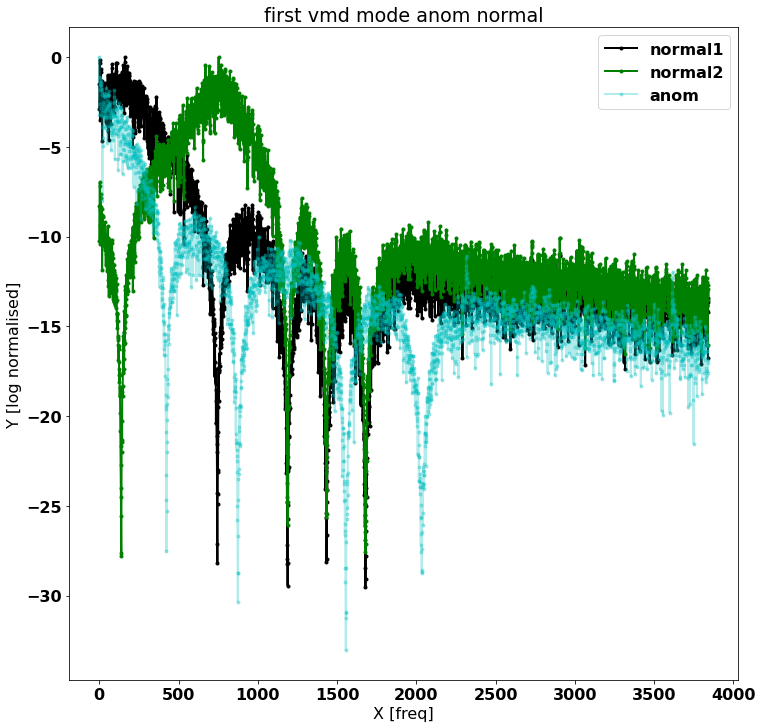

In [19]:
plt.figure(figsize=(12,12))
plt.plot(norm_vmd[0][0], 'k.-', linewidth=2, label="normal1")
plt.plot(norm_vmd[0][1], 'g.-', linewidth=2,label="normal2")
plt.plot(anom_vmd[0][0], 'c.-', linewidth=2, alpha=0.3, label="anom")
plt.title("first vmd mode anom normal")
plt.legend()
plt.xlabel("X [freq]")
plt.ylabel("Y [log normalised]") #plotting first vmd of normal1 and normal2 seq and anom seq.


In [20]:
# stack welch transformed data together
norm_seq = []
anom_seq = []

#stack normal together
for j in range(num_modes):
    stack_list = []
    for i in range(seg_norm):
        stack_list.append(norm_vmd[i][j])
    norm_seq.append(np.hstack(stack_list))

    # stack anomalous together 
    stack_list = []
    for i in range(seg_anom):
        stack_list.append(anom_vmd[i][j])
    anom_seq.append(np.hstack(stack_list))

norm_seq = np.array(norm_seq)
anom_seq = np.array(anom_seq)


In [22]:
norm_seq.shape # 5 vmd, each with 20 concatenated normal sequences

(5, 76820)

In [23]:
anom_seq.shape # 5 vmd, each with 10 concatenated anomalous sequences

(5, 38410)

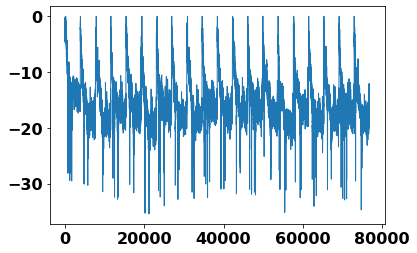

In [24]:
plt.plot(norm_seq[0], linewidth = 1) # check first vmd concatenation

In [25]:
sum(np.isnan(anom_seq[0])) # NaNs? Why? (look back above: one of the sensors only gave a single measurement)

3841

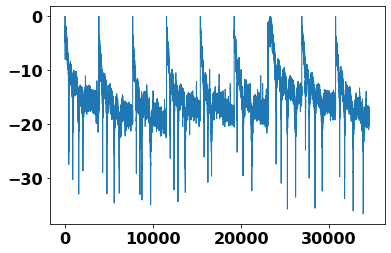

In [26]:
plt.plot(anom_seq[0], linewidth=1)

In [27]:
# compute mps and cacs
# ot together cacs among different vmd; compare with averaging. can you detect a shift in context?

In [31]:
total_seq = np.hstack([norm_seq, anom_seq])


In [32]:
total_seq.shape # first 20 are normal, next 10 are anomalous in some way 

(5, 115230)

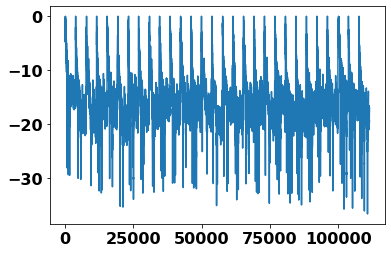

In [33]:
plt.plot(total_seq[0])

In [34]:
# build an array of tuples, where the first is mp and the second is cac

MP_period = norm_vmd[0][0].shape[0] #3841

total_MP_CAC = []

for j in range(num_modes):
    vmd_str = f"vmd{j}"
    mp = stumpy.stump(total_seq[j], m=MP_period)
    cac = _cac(mp[:, 3], L=MP_period, bidirectional=False, excl_factor=1)
    total_MP_CAC.append((mp,cac))



In [35]:
total_MP_CAC[0][1] # 1st vmd; 0 is mp computation, 1 is cac

array([1., 1., 1., ..., 1., 1., 1.])

In [123]:
first_nan = np.argwhere(np.isnan(total_seq[0]))[0] # just me figuring out what is happening with NaNs

Text(0.02, 0.5, 'Normalised magnitudes')

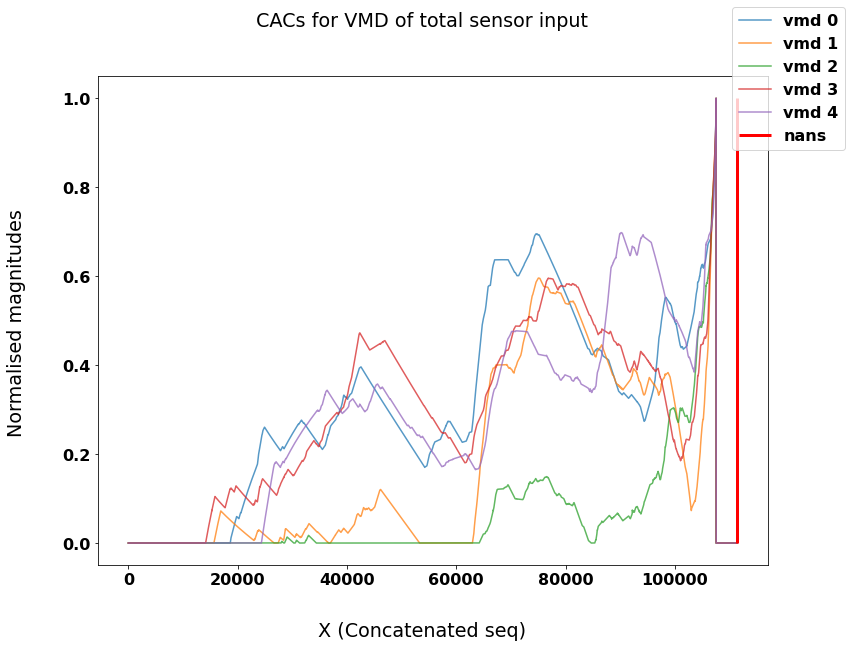

In [127]:
fig, ax = plt.subplots(1,1,figsize=(12,9))
for i in range(num_modes):
    ax.plot(1-total_MP_CAC[i][1], alpha=0.75, label=f"vmd {i}") #5 vmd modes plotted together

ax.vlines(first_nan, color='r', ymin=0, ymax=1, linewidth=3, label="nans")
fig.legend()
fig.suptitle("CACs for VMD of total sensor input")
fig.supxlabel("X (Concatenated seq)")
fig.supylabel("Normalised magnitudes")

# looks alright


In [38]:
# ot together the CACs from different VMD
sub_sample_rate = 10
A = np.array([total_MP_CAC[i][1][::sub_sample_rate] for i in range(num_modes)]).T
M = ot.utils.dist0(A.shape[0])
M /= M.max()
M *= 1e4 # this is for tuning - will this work for our problem?
bary_wass = ot.barycenter_unbalanced(A, M, reg=5e-4, reg_m=1e-1)



In [107]:
shift_factor = MP_period // sub_sample_rate
theoretical_peaks = np.array([MP_period * 20, MP_period * (30-1)]) // sub_sample_rate
found_peaks = np.array(find_peaks(1-bary_wass, height=0.485, distance=1000)[0]) #configure parameters
xs = np.arange(len(bary_wass))
xs_shifted = xs + shift_factor
# i haven't done anything with the shift factor 

In [116]:
total_seq[0][::sub_sample_rate][-384:] # again, me discovering the last 384 are NaNs because broken sensor

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

Text(0.5, 0.98, 'Concatenated VMD with CAC + theoretical peaks overlaid (context change)')

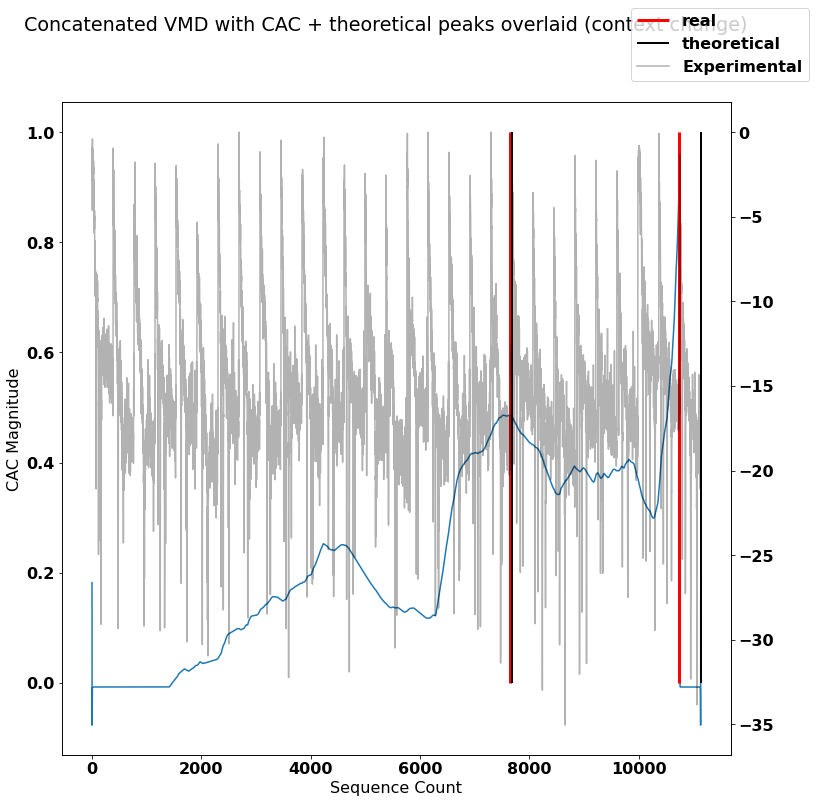

In [108]:
fig, axs = plt.subplots(1,1, figsize=(12,12))
axs.plot(xs, 1-bary_wass)

ax2 = axs.twinx()
ax2.plot(total_seq[0][::sub_sample_rate],'k', alpha=0.3, label="Experimental")

axs.vlines(x = found_peaks, ymin=0, ymax = 1, linewidth=3,color="r", label="real")
axs.vlines(x = theoretical_peaks, ymin=0, ymax=1,linewidth=2 ,color="k", alpha=1, label="theoretical")

axs.set_ylabel("CAC Magnitude")
axs.set_xlabel("Sequence Count")

fig.legend()

fig.suptitle("Concatenated VMD with CAC + theoretical peaks overlaid (context change)")


In [135]:
shift_factor

384

In [131]:
len(xs_shifted) - found_peaks[1]

390

In [129]:
found_peaks[1]

10749

In [130]:
len(xs_shifted)

11139

In [87]:
len(total_seq[0][::sub_sample_rate])

11523

# Future Directions 
- Clean up data process
- What's happening with the NaNs? What happens if I replace that kind of anomalous sensor with something else that is working?
- Figure out what is happening with shift factor and what is happening with that gap?? (is it the nans, how does CAC work with nans??)
- Compare results with just averaging and also just taking the first vmd mode, 2nd, ...
- Try some parameter tuning - does it change smoothness??
- Try including different numbers of anomalous segments

## Hypothesis
- Matrix profiles are good at dealing with contextual changes are consistent (e.g. bookshelf had similar kinds of "damage" happening)
- Helicopter dataset is more disorganised - the type of damage/anomalous behaviour can be very different, sensors can be placed in different positions/angles (without record)
- Learning approach better for this kind of situation ?? 